<a href="https://colab.research.google.com/github/Justworkname/Tamil_lab_Chance_Gammill/blob/main/CFar_ViT_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vit CFar

## Import

In [ ]:
!pip install -q torchinfo

In [ ]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import has_file_allowed_extension
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Hyper parameters

In [ ]:
# Transfer learning
# 2 classes?
# add grad cam
# pytorch lightning
num_epochs=50
batch_size=5
img_size=32
in_channels=3 #RGB
patch_size=4
embedding_dim=384 ## 384
head=12 # flash attention # heads per feature is 64 embeding dim/64,32,16
dropout=0.1
hidden_size=1536 # 4 times embeiding dimesions
layers = 8
num_classes=10 # will be over written in data phase

## Data

Transform

In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

Load

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes=len(class_names)
train_loader, test_loader,class_names

Files already downloaded and verified
Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7c9028bf73d0>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

Visualize Image

In [ ]:
image_batch, label_batch = next(iter(train_loader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 32, 32]), tensor(0))

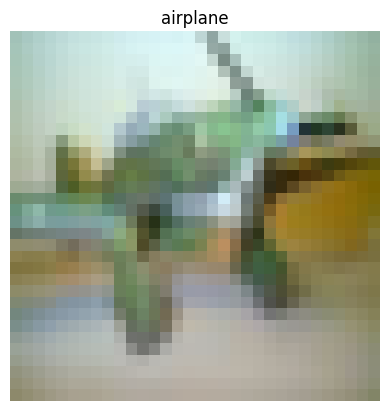

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Patch embeding layer

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=in_channels,
                 patch_size=patch_size,
                 embedding_dim=embedding_dim):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,  # Corrected typo from kernels_size to kernel_size
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self,x):
        image_resolution = x.shape[-1]

        x_patched =self.patcher(x)
        x_flattened= self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

## Transformer Encoder Layer

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                       nhead=head,
                                                       dim_feedforward=hidden_size,
                                                       dropout=dropout,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
  )
  (linear1): Linear(in_features=384, out_features=1536, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1536, out_features=384, bias=True)
  (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Display Model

In [ ]:
summary(model=transformer_encoder_layer)

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          443,520
│    └─NonDynamicallyQuantizableLinear: 2-1        147,840
├─Linear: 1-2                                      591,360
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      590,208
├─LayerNorm: 1-5                                   768
├─LayerNorm: 1-6                                   768
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
Total params: 1,774,464
Trainable params: 1,774,464
Non-trainable params: 0

## Stack Transformer Encoder

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=layers)


In [ ]:
summary(model=transformer_encoder)

Layer (type:depth-idx)                                       Param #
TransformerEncoder                                           --
├─ModuleList: 1-1                                            --
│    └─TransformerEncoderLayer: 2-1                          --
│    │    └─MultiheadAttention: 3-1                          591,360
│    │    └─Linear: 3-2                                      591,360
│    │    └─Dropout: 3-3                                     --
│    │    └─Linear: 3-4                                      590,208
│    │    └─LayerNorm: 3-5                                   768
│    │    └─LayerNorm: 3-6                                   768
│    │    └─Dropout: 3-7                                     --
│    │    └─Dropout: 3-8                                     --
│    └─TransformerEncoderLayer: 2-2                          --
│    │    └─MultiheadAttention: 3-9                          591,360
│    │    └─Linear: 3-10                                     591,360
│    │  

## ViT

In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=img_size,
                 in_channels=in_channels,
                 patch_size=patch_size,
                 embedding_dim=embedding_dim,
                 dropout=dropout,
                 hidden_size=hidden_size,
                 layers=layers,
                 head=head,
                 num_classes=num_classes):
      super().__init__()

      # patch embedding
      self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                           patch_size=patch_size,
                                           embedding_dim=embedding_dim)
      # class token
      self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim),
                                      requires_grad=True)
      # positional Embedding
      num_patches = img_size**2 // patch_size**2
      self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

      # Create Patch + Positional embedding
      self.embedding_dropout = nn.Dropout(p=dropout)

      # Create stack TransformerEncoder Layers
      self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                nhead=head,
                                                                                                dim_feedforward=hidden_size,
                                                                                                activation="gelu",
                                                                                                batch_first=True,
                                                                                                norm_first=True),
                                                        num_layers=layers)
      # MLP head
      self.mlp_head = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)
      )

    def forward(self,x):
      # batch size
      batch_size = x.shape[0]

      # patch embedding
      x = self.patch_embedding(x)

      # expand class token
      class_token = self.class_token.expand(batch_size,-1,-1)

      # Prepend the class token to the patch embedding
      x = torch.cat(( class_token,x), dim=1)

      # add the positional embedding to patch embedding
      x = self.positional_embedding + x

      # dropout on patch
      x = self.embedding_dropout(x)

      # Pass embeding through transformer stack
      x = self.transformer_encoder(x)

      # pass 0th index of x through MLP head
      x = self.mlp_head(x[:,0])

      return x

In [ ]:
# Create Vit
vit = ViT(num_classes=num_classes).to(device)

In [ ]:
summary(model=ViT(num_classes=3))

Layer (type:depth-idx)                                            Param #
ViT                                                               25,344
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                18,816
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          1,774,464
│    │    └─TransformerEncoderLayer: 3-2                          1,774,464
│    │    └─TransformerEncoderLayer: 3-3                          1,774,464
│    │    └─TransformerEncoderLayer: 3-4                          1,774,464
│    │    └─TransformerEncoderLayer: 3-5                          1,774,464
│    │    └─TransformerEncoderLayer: 3-6               

## Training

In [ ]:
# Create Vit
vit = ViT(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=0.0005, weight_decay=0.05)

from tqdm import tqdm

# Training loop
for epoch in range(num_epochs):
    # Initialize
    batch_count= 0
    total_loss = 0.0
    correct_predictions = 0

    # Train
    vit.train()

    # batch loop
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    bar.set_description(f"Epoch {epoch}")
    seen_examples = 0
    for batch_idx, (data, target) in bar:
        data = data.to(device)
        target = target.to(device)
        batch_count=batch_count+1
        optimizer.zero_grad()
        output = vit(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Corect prediction count
        _, predicted = output.max(1)

        correct_predictions += predicted.eq(target).sum().item()
        seen_examples += len(data)

        bar.set_postfix(loss=loss.item(), accuracy=100. * correct_predictions / seen_examples)

        # Total Loss
        total_loss += loss.item()

    # Calculate training accuracy
    training_accuracy = correct_predictions / len(train_loader.dataset)

    # Initialize counters for loss and correct predictions in validation
    val_loss = 0.0
    val_correct_predictions = 0

    # Set the model to evaluation mode (no gradient calculation)
    vit.eval()

    # Iterate over the validation data
    with torch.no_grad():
        for val_data, val_target in test_loader:
            val_data=val_data.to(device)
            val_target=val_target.to(device)
            val_output = vit(val_data)
            val_loss += criterion(val_output, val_target).item()

            # Calculate the number of correct predictions in this validation batch
            _, val_predicted = val_output.max(1)
            val_correct_predictions += val_predicted.eq(val_target).sum().item()

    # Calculate validation accuracy
    validation_accuracy = val_correct_predictions / len(test_loader.dataset)

    # Print training and validation progress for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {total_loss/batch_count:.4f} Training Accuracy: {training_accuracy:.4f} Validation Loss: {val_loss/len(test_loader):.4f} Validation Accuracy: {validation_accuracy:.4f}")


Epoch 0: 100%|██████████| 10000/10000 [05:31<00:00, 30.12it/s, accuracy=24.4, loss=1.8]


Epoch [1/50] Training Loss: 2.0371 Training Accuracy: 0.2443 Validation Loss: 1.8590 Validation Accuracy: 0.3212


Epoch 1: 100%|██████████| 10000/10000 [05:15<00:00, 31.67it/s, accuracy=33.5, loss=1.48]


Epoch [2/50] Training Loss: 1.8268 Training Accuracy: 0.3351 Validation Loss: 1.7699 Validation Accuracy: 0.3510


Epoch 2: 100%|██████████| 10000/10000 [05:15<00:00, 31.68it/s, accuracy=37.5, loss=1.28]


Epoch [3/50] Training Loss: 1.7218 Training Accuracy: 0.3752 Validation Loss: 1.6955 Validation Accuracy: 0.3940


Epoch 3: 100%|██████████| 10000/10000 [05:15<00:00, 31.74it/s, accuracy=40.5, loss=1.83]


Epoch [4/50] Training Loss: 1.6433 Training Accuracy: 0.4047 Validation Loss: 1.5900 Validation Accuracy: 0.4244


Epoch 4: 100%|██████████| 10000/10000 [05:15<00:00, 31.69it/s, accuracy=43.4, loss=2.07]


Epoch [5/50] Training Loss: 1.5735 Training Accuracy: 0.4336 Validation Loss: 1.5070 Validation Accuracy: 0.4558


Epoch 5: 100%|██████████| 10000/10000 [05:15<00:00, 31.68it/s, accuracy=46, loss=1.51]


Epoch [6/50] Training Loss: 1.4897 Training Accuracy: 0.4603 Validation Loss: 1.4892 Validation Accuracy: 0.4681


Epoch 6: 100%|██████████| 10000/10000 [05:15<00:00, 31.73it/s, accuracy=48.5, loss=1.25]


Epoch [7/50] Training Loss: 1.4261 Training Accuracy: 0.4851 Validation Loss: 1.3867 Validation Accuracy: 0.5085


Epoch 7: 100%|██████████| 10000/10000 [05:14<00:00, 31.77it/s, accuracy=50.5, loss=1.2]


Epoch [8/50] Training Loss: 1.3735 Training Accuracy: 0.5046 Validation Loss: 1.3906 Validation Accuracy: 0.5057


Epoch 8: 100%|██████████| 10000/10000 [05:15<00:00, 31.71it/s, accuracy=52.2, loss=1.26]


Epoch [9/50] Training Loss: 1.3303 Training Accuracy: 0.5216 Validation Loss: 1.2825 Validation Accuracy: 0.5358


Epoch 9: 100%|██████████| 10000/10000 [05:14<00:00, 31.76it/s, accuracy=53.6, loss=1.31]


Epoch [10/50] Training Loss: 1.2928 Training Accuracy: 0.5359 Validation Loss: 1.2617 Validation Accuracy: 0.5452


Epoch 10: 100%|██████████| 10000/10000 [05:14<00:00, 31.82it/s, accuracy=54.7, loss=2.31]


Epoch [11/50] Training Loss: 1.2607 Training Accuracy: 0.5469 Validation Loss: 1.2413 Validation Accuracy: 0.5521


Epoch 11: 100%|██████████| 10000/10000 [05:14<00:00, 31.81it/s, accuracy=55.8, loss=1.06]


Epoch [12/50] Training Loss: 1.2315 Training Accuracy: 0.5579 Validation Loss: 1.2832 Validation Accuracy: 0.5437


Epoch 12: 100%|██████████| 10000/10000 [05:15<00:00, 31.73it/s, accuracy=56.5, loss=1.81]


Epoch [13/50] Training Loss: 1.2064 Training Accuracy: 0.5655 Validation Loss: 1.2302 Validation Accuracy: 0.5554


Epoch 13: 100%|██████████| 10000/10000 [05:16<00:00, 31.60it/s, accuracy=57.7, loss=1.01]


Epoch [14/50] Training Loss: 1.1834 Training Accuracy: 0.5770 Validation Loss: 1.1932 Validation Accuracy: 0.5666


Epoch 14: 100%|██████████| 10000/10000 [05:15<00:00, 31.73it/s, accuracy=58.2, loss=0.824]


Epoch [15/50] Training Loss: 1.1636 Training Accuracy: 0.5824 Validation Loss: 1.1890 Validation Accuracy: 0.5700


Epoch 15: 100%|██████████| 10000/10000 [05:14<00:00, 31.77it/s, accuracy=58.6, loss=0.982]


Epoch [16/50] Training Loss: 1.1589 Training Accuracy: 0.5861 Validation Loss: 1.2199 Validation Accuracy: 0.5717


Epoch 16: 100%|██████████| 10000/10000 [05:15<00:00, 31.73it/s, accuracy=59.1, loss=1.34]


Epoch [17/50] Training Loss: 1.1452 Training Accuracy: 0.5914 Validation Loss: 1.1844 Validation Accuracy: 0.5799


Epoch 17: 100%|██████████| 10000/10000 [05:17<00:00, 31.51it/s, accuracy=59.7, loss=0.44]


Epoch [18/50] Training Loss: 1.1304 Training Accuracy: 0.5974 Validation Loss: 1.2694 Validation Accuracy: 0.5650


Epoch 18: 100%|██████████| 10000/10000 [05:16<00:00, 31.56it/s, accuracy=60, loss=1.58]


Epoch [19/50] Training Loss: 1.1185 Training Accuracy: 0.6004 Validation Loss: 1.1593 Validation Accuracy: 0.5882


Epoch 19: 100%|██████████| 10000/10000 [05:16<00:00, 31.61it/s, accuracy=60.3, loss=2.29]


Epoch [20/50] Training Loss: 1.1098 Training Accuracy: 0.6027 Validation Loss: 1.1307 Validation Accuracy: 0.5964


Epoch 20: 100%|██████████| 10000/10000 [05:16<00:00, 31.61it/s, accuracy=60.2, loss=1.02]


Epoch [21/50] Training Loss: 1.1054 Training Accuracy: 0.6023 Validation Loss: 1.1402 Validation Accuracy: 0.5930


Epoch 21: 100%|██████████| 10000/10000 [05:16<00:00, 31.63it/s, accuracy=61, loss=0.732]


Epoch [22/50] Training Loss: 1.0921 Training Accuracy: 0.6099 Validation Loss: 1.1183 Validation Accuracy: 0.5985


Epoch 22: 100%|██████████| 10000/10000 [05:14<00:00, 31.76it/s, accuracy=61.3, loss=1.19]


Epoch [23/50] Training Loss: 1.0870 Training Accuracy: 0.6128 Validation Loss: 1.1468 Validation Accuracy: 0.6011


Epoch 23: 100%|██████████| 10000/10000 [05:14<00:00, 31.78it/s, accuracy=61.4, loss=0.872]


Epoch [24/50] Training Loss: 1.0803 Training Accuracy: 0.6144 Validation Loss: 1.1054 Validation Accuracy: 0.6078


Epoch 24: 100%|██████████| 10000/10000 [05:16<00:00, 31.55it/s, accuracy=61.3, loss=1.4]


Epoch [25/50] Training Loss: 1.0770 Training Accuracy: 0.6132 Validation Loss: 1.1704 Validation Accuracy: 0.5872


Epoch 25: 100%|██████████| 10000/10000 [05:17<00:00, 31.52it/s, accuracy=62, loss=1.02]


Epoch [26/50] Training Loss: 1.0645 Training Accuracy: 0.6201 Validation Loss: 1.0930 Validation Accuracy: 0.6061


Epoch 26: 100%|██████████| 10000/10000 [05:16<00:00, 31.62it/s, accuracy=62.1, loss=1.85]


Epoch [27/50] Training Loss: 1.0624 Training Accuracy: 0.6209 Validation Loss: 1.1209 Validation Accuracy: 0.6032


Epoch 27: 100%|██████████| 10000/10000 [05:16<00:00, 31.57it/s, accuracy=62.3, loss=0.851]


Epoch [28/50] Training Loss: 1.0543 Training Accuracy: 0.6230 Validation Loss: 1.1128 Validation Accuracy: 0.6052


Epoch 28: 100%|██████████| 10000/10000 [05:16<00:00, 31.62it/s, accuracy=62.5, loss=1.28]


Epoch [29/50] Training Loss: 1.0490 Training Accuracy: 0.6250 Validation Loss: 1.0960 Validation Accuracy: 0.6015


Epoch 29: 100%|██████████| 10000/10000 [05:18<00:00, 31.37it/s, accuracy=62.7, loss=1.76]


Epoch [30/50] Training Loss: 1.0408 Training Accuracy: 0.6272 Validation Loss: 1.1248 Validation Accuracy: 0.6066


Epoch 30: 100%|██████████| 10000/10000 [05:14<00:00, 31.77it/s, accuracy=63.2, loss=1.09]


Epoch [31/50] Training Loss: 1.0376 Training Accuracy: 0.6322 Validation Loss: 1.0831 Validation Accuracy: 0.6188


Epoch 31: 100%|██████████| 10000/10000 [05:18<00:00, 31.41it/s, accuracy=63.2, loss=1.02]


Epoch [32/50] Training Loss: 1.0330 Training Accuracy: 0.6318 Validation Loss: 1.0784 Validation Accuracy: 0.6170


Epoch 32: 100%|██████████| 10000/10000 [05:17<00:00, 31.49it/s, accuracy=63.4, loss=1.01]


Epoch [33/50] Training Loss: 1.0255 Training Accuracy: 0.6340 Validation Loss: 1.0749 Validation Accuracy: 0.6229


Epoch 33: 100%|██████████| 10000/10000 [05:15<00:00, 31.65it/s, accuracy=63.6, loss=1.01]


Epoch [34/50] Training Loss: 1.0237 Training Accuracy: 0.6364 Validation Loss: 1.1040 Validation Accuracy: 0.6062


Epoch 34: 100%|██████████| 10000/10000 [05:16<00:00, 31.61it/s, accuracy=63.7, loss=0.694]


Epoch [35/50] Training Loss: 1.0192 Training Accuracy: 0.6369 Validation Loss: 1.1146 Validation Accuracy: 0.6100


Epoch 35: 100%|██████████| 10000/10000 [05:17<00:00, 31.54it/s, accuracy=63.8, loss=0.762]


Epoch [36/50] Training Loss: 1.0138 Training Accuracy: 0.6384 Validation Loss: 1.0633 Validation Accuracy: 0.6212


Epoch 36: 100%|██████████| 10000/10000 [05:16<00:00, 31.57it/s, accuracy=63.8, loss=1.04]


Epoch [37/50] Training Loss: 1.0123 Training Accuracy: 0.6380 Validation Loss: 1.0989 Validation Accuracy: 0.6037


Epoch 37: 100%|██████████| 10000/10000 [05:16<00:00, 31.63it/s, accuracy=64, loss=0.69]


Epoch [38/50] Training Loss: 1.0074 Training Accuracy: 0.6399 Validation Loss: 1.2086 Validation Accuracy: 0.5898


Epoch 38: 100%|██████████| 10000/10000 [05:16<00:00, 31.56it/s, accuracy=64.3, loss=0.443]


Epoch [39/50] Training Loss: 1.0059 Training Accuracy: 0.6426 Validation Loss: 1.0756 Validation Accuracy: 0.6151


Epoch 39: 100%|██████████| 10000/10000 [05:15<00:00, 31.71it/s, accuracy=64.3, loss=0.667]


Epoch [40/50] Training Loss: 1.0025 Training Accuracy: 0.6431 Validation Loss: 1.0970 Validation Accuracy: 0.6206


Epoch 40: 100%|██████████| 10000/10000 [05:15<00:00, 31.65it/s, accuracy=64.6, loss=1.28]


Epoch [41/50] Training Loss: 0.9943 Training Accuracy: 0.6459 Validation Loss: 1.1517 Validation Accuracy: 0.5891


Epoch 41: 100%|██████████| 10000/10000 [05:15<00:00, 31.70it/s, accuracy=64.5, loss=1.56]


Epoch [42/50] Training Loss: 0.9994 Training Accuracy: 0.6451 Validation Loss: 1.1435 Validation Accuracy: 0.6012


Epoch 42: 100%|██████████| 10000/10000 [05:16<00:00, 31.59it/s, accuracy=64.9, loss=1.03]


Epoch [43/50] Training Loss: 0.9875 Training Accuracy: 0.6494 Validation Loss: 1.0925 Validation Accuracy: 0.6136


Epoch 43: 100%|██████████| 10000/10000 [05:14<00:00, 31.78it/s, accuracy=65, loss=0.759]


Epoch [44/50] Training Loss: 0.9864 Training Accuracy: 0.6496 Validation Loss: 1.1643 Validation Accuracy: 0.5913


Epoch 44: 100%|██████████| 10000/10000 [05:17<00:00, 31.47it/s, accuracy=64.8, loss=0.583]


Epoch [45/50] Training Loss: 0.9866 Training Accuracy: 0.6476 Validation Loss: 1.0548 Validation Accuracy: 0.6234


Epoch 45: 100%|██████████| 10000/10000 [05:16<00:00, 31.58it/s, accuracy=65, loss=1.06]


Epoch [46/50] Training Loss: 0.9829 Training Accuracy: 0.6500 Validation Loss: 1.1016 Validation Accuracy: 0.6096


Epoch 46: 100%|██████████| 10000/10000 [05:16<00:00, 31.61it/s, accuracy=65.1, loss=0.981]


Epoch [47/50] Training Loss: 0.9818 Training Accuracy: 0.6512 Validation Loss: 1.0956 Validation Accuracy: 0.6077


Epoch 47: 100%|██████████| 10000/10000 [05:15<00:00, 31.70it/s, accuracy=65.1, loss=1.49]


Epoch [48/50] Training Loss: 0.9783 Training Accuracy: 0.6513 Validation Loss: 1.1432 Validation Accuracy: 0.5867


Epoch 48: 100%|██████████| 10000/10000 [05:17<00:00, 31.50it/s, accuracy=65.2, loss=1.3]


Epoch [49/50] Training Loss: 0.9755 Training Accuracy: 0.6519 Validation Loss: 1.1052 Validation Accuracy: 0.6110


Epoch 49: 100%|██████████| 10000/10000 [05:15<00:00, 31.66it/s, accuracy=65.2, loss=0.906]


Epoch [50/50] Training Loss: 0.9726 Training Accuracy: 0.6520 Validation Loss: 1.1427 Validation Accuracy: 0.6114
